In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Dataset/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [3]:
# df['class'] = df['overall'].map(lambda x: 'Like' if 4<=x<=5 else 'Neutral' if x==3 else 'Dislike')

In [4]:
df['CLASS'] = df['overall'].map(lambda x: 1 if 3<=x<=5 else 0)

In [5]:
df['V1'] = df['overall'].map(lambda x: 'Like' if 3<=x<=5 else 'Dislike')

In [6]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,CLASS,V1
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",1,Like
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",1,Like
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",1,Like
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",1,Like
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",1,Like


In [7]:
df.overall.value_counts()

5.0    163240
4.0     58357
3.0     30425
2.0     15463
1.0     11192
Name: overall, dtype: int64

In [8]:
df.CLASS.value_counts()

1    252022
0     26655
Name: CLASS, dtype: int64

In [9]:
df.V1.value_counts()

Like       252022
Dislike     26655
Name: V1, dtype: int64

In [10]:
data = df.drop(['reviewerID', 'asin', 'reviewerName','helpful','unixReviewTime','reviewTime','summary'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278677 entries, 0 to 278676
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewText  278677 non-null  object 
 1   overall     278677 non-null  float64
 2   CLASS       278677 non-null  int64  
 3   V1          278677 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 10.6+ MB


In [11]:
data['WORDS'] = data['reviewText'].map(lambda x: len(x.split()))
data.head()

,reviewText,overall,CLASS,V1,WORDS
0,This is a great tutu and at a really great pri...,5.0,1,Like,35
1,I bought this for my 4 yr old daughter for dan...,5.0,1,Like,61
2,What can I say... my daughters have it in oran...,5.0,1,Like,62
3,"We bought several tutus at once, and they are ...",5.0,1,Like,76
4,Thank you Halo Heaven great product for Little...,5.0,1,Like,80


In [12]:
data['WORDS'].describe()

count    278677.000000
mean         59.953046
std          61.289861
min           0.000000
25%          26.000000
50%          41.000000
75%          70.000000
max        3882.000000
Name: WORDS, dtype: float64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278677 entries, 0 to 278676
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewText  278677 non-null  object 
 1   overall     278677 non-null  float64
 2   CLASS       278677 non-null  int64  
 3   V1          278677 non-null  object 
 4   WORDS       278677 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 12.8+ MB


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Number of Like(1) and Dislike(0)')

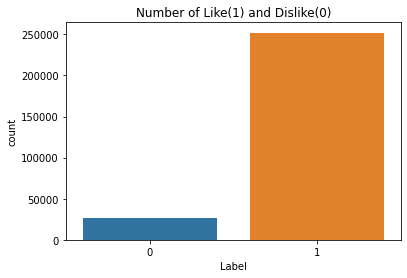

In [15]:
sns.countplot(data['CLASS'])
plt.xlabel('Label')
plt.title('Number of Like(1) and Dislike(0)')

In [16]:
X = data.reviewText # input 
Y = df['CLASS'] # output

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [18]:
max_words = 1000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train) 
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [19]:
print(sequences[:2])

[[2, 38, 889, 38, 38, 38, 15, 10, 169, 79, 6, 8, 45, 6, 202, 30, 28, 146, 930, 5, 2, 74, 197, 41, 51, 64, 9, 12, 39, 88, 2, 25, 630, 6, 35, 30, 28, 1, 224, 15, 6, 169, 2, 394, 168, 1, 758, 5, 12, 29, 51, 102, 4, 37, 71, 112, 24, 137, 54, 96, 536, 268], [23, 115, 15, 56, 5, 299, 44, 73, 8, 12, 798, 65, 2, 372, 31, 4, 29, 270, 282, 207, 29, 98, 46, 135, 20, 5, 45]]


In [20]:
sequences_matrix[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
         38, 889,  38,  38,  38,  15,  10, 169,  79,   6,   8,  45,   6,
        202,  30,  28, 146, 930,   5,   2,  74, 197,  41,  51,  64,   9,
         12,  39,  88,   2,  25, 630,   6,  35,  30,  28,   1, 224,  15,
          6, 169,   2, 394, 168,   1, 758,   5,  12,  29,  51, 102,   4,
         37,  71, 112,  24, 137,  54,  96, 536, 268],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  23, 115,  15,  56,   

### RNN

In [21]:
# Define model
model = Sequential()
model.add(Embedding(max_words, 50))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [22]:
# compile
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

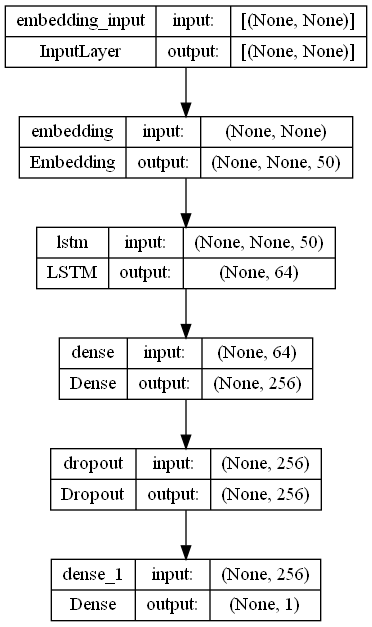

In [25]:
plot_model(model, to_file='LSTM_model.png', show_shapes=True)
Image(filename='LSTM_model.png')

In [26]:
# fit
history = model.fit(sequences_matrix, Y_train,
                    batch_size=120,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1301/1301 [==============================] - 122s 92ms/step - loss: 0.2159 - accuracy: 0.9169 - val_loss: 0.2077 - val_accuracy: 0.9112
Epoch 2/50
1301/1301 [==============================] - 138s 106ms/step - loss: 0.1881 - accuracy: 0.9250 - val_loss: 0.1790 - val_accuracy: 0.9280
Epoch 3/50
1301/1301 [==============================] - 143s 110ms/step - loss: 0.1747 - accuracy: 0.9293 - val_loss: 0.1719 - val_accuracy: 0.9294
Epoch 4/50
1301/1301 [==============================] - 140s 107ms/step - loss: 0.1657 - accuracy: 0.9322 - val_loss: 0.1645 - val_accuracy: 0.9309
Epoch 5/50
1301/1301 [==============================] - 130s 100ms/step - loss: 0.1595 - accuracy: 0.9343 - val_loss: 0.1585 - val_accuracy: 0.9342
Epoch 6/50
1301/1301 [==============================] - 131s 100ms/step - loss: 0.1552 - accuracy: 0.9362 - val_loss: 0.1655 - val_accuracy: 0.9332
Epoch 7/50
1301/1301 [==============================] - 132s 102ms/step - loss: 0.1510 - accuracy: 0.9381 - val_l

In [27]:
# test: text to sequence
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [28]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2613/2613 [==============================] - 39s 15ms/step - loss: 0.1642 - accuracy: 0.9346


In [29]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.164
  Accuracy: 0.935


##### Comment:
- The model reached 93% accuracy